### Disclaimer
This notebook is based on a notebook made by Chris Rackauckas available at https://github.com/UCIDataScienceInitiative/IntroToJulia

# My Reasons to Use Julia
- I want to write code which is "slick" and readable (Code is read more than code is written!)
- I want that same code to be fast
- I prefer to write everything in one language
- I am a developer: I want to write packages really fast which are really fast!
- I am a package user: I heard about some really cool Julia packages/metapackages (JuMP, Plots, DifferentialEquations, Flux, Zygote, Distributions, Turing, ), and want to use Julia
- I want built-in and easy native parallelism

## Other reasons
- I want to build your own Domain-Specific Language (DSL), compiler, etc.

## Why not to use Julia
- Everyone uses Python.
- I am fine by calling libraries someone else has written.
- I do miss some libraries.
- I have a legacy code.
- I cannot swallow compilation time (https://github.com/JuliaLang/PackageCompiler.jl)

## I want to write code which is "slick" and readable
- Julia supports anonymous functions, closures, and functors (more on this later). While this is available in other languages (python uses lambda syntax for anonymous function and partial from some other pkf to make the closure), these constructs in Julia represents zero cost abstractions.
- you don't have to write nasty=optimized in order to run fast
    + close to mathematical representation
    + no need to write out for loops or fuse things unnaturally in order to make it faster (vectorization in MATLAB)
    + the nastiness in optimization mainly stems from cases, where you want to avoid allocation of memory
- the dot syntax
    + for arithmetic operation but also for any generic function
    + intuitive broadcasting over tensors
    + it is internally fused in single for loop by the compiler


In [1]:
using Flux, Flux.Tracker
using Base.Math: clamp
using Flux: data

function fgsm(f::Function, x, ϵ::Real) 
    ∇f = data(Tracker.gradient(f, x)[1])
    x .- ϵ .* sign.(∇f)
end

f = Chain(Dense(10, 4, relu), Dense(4,2), softmax)
x = randn(10,1)

@show f(x)[1]
xx = fgsm(x -> f(x)[1], x, 0.1)
@show f(xx)[1];

(f(x))[1] = 0.4431126f0 (tracked)
(f(xx))[1] = 0.40939623f0 (tracked)


In [2]:
function pgd(f::Function, x, α::Real, steps::Integer, proj::Function)
    δ = zeros(size(x,1))
    for i in 1:steps
        ∇f = Tracker.gradient(δ->f(x + δ), δ)[1].data
        δ = proj(δ .- α .* ∇f)
    end
    x .+ δ
end

@show f(x)[1]
xx = pgd(x -> f(x)[1], x, 0.1, 100, x -> clamp.(x , -0.5, 0.5))
@show f(xx)[1];

(f(x))[1] = 0.4431126f0 (tracked)
(f(xx))[1] = 0.2652276f0 (tracked)


## Why single language matters?
- It si flexible, as it allows you to easily combine very different libraries.
- For example DifferentialEquations.jl with Flux.jl offers to use neural networks inside differential equations and vice versa.
- An independent package for GPU computing allows to DifferentialEquations or Flux to utilize the power of GPU, *without writing any special code* for GPU (compare this to TensorFlow or PyTorch, which ships with their own implementations of functions executed on GPU).
- We have prototyped Graph neural networks with rich descriptions of vertices by combining LightGraphs, MetaGraphs, Mill.jl in one evening.
- When you use callback functions, you might need to cross bariers between two languages, which costs you time. This is important in optimization libraries.
- Personally, I do not have time to master a single language, cannot think about two or more.

## Why Does Julia Work So Well?

There is an obvious reason to choose Julia:

>it's faster than other scripting languages, allowing you to have the rapid development of Python/MATLAB/R while producing code that is as fast as C/Fortran

Newcomers to Julia might be a little wary of that statement.

1. Why not just make other scripting languages faster? If Julia can do it, why can't others? 
2. How do you interpert Julia benchmarks to confirm this? (This is surprisingly difficult for many!)
2. That sounds like it violates the No-Free-Lunch heuristic. Is there really nothing lost?

Many people believe Julia is fast **because it is Just-In-Time (JIT) compiled** (i.e. every statement is run using compiled functions which are either compiled right before they are used, or cached compilations from before). This leads to questions about what Julia gives over JIT'd implementations of Python/R (and MATLAB by default uses a JIT). These JIT compilers have been optimized for far longer than Julia, so why should we be crazy and believe that somehow Julia quickly out-optimized all of them? However, that is a complete misunderstanding of Julia. What I want show, in a very visual way, is that Julia is fast because of its design decisions. The core design decision, **type-stability through specialization via multiple-dispatch** is what allows Julia to be very easy for a compiler to make into efficient code, but also allow the code to be very concise and "look like a scripting language". This will lead to some very clear performance gains.

But what we will see in this example is that Julia does not always act like other scripting languages. There are some "lunches lost" that we will have to understand. Understanding how this design decision effects the way you must code is crucial to producing efficient Julia code.

To see the difference, we only need to go as far as basic math.

## Arithmetic in Julia

In general, math in Julia looks the same as in other scripting languages. One detail to note is that the numbers are "true numbers", as in a `Float64` is truly the same thing as a 64-bit floating point number or a "double" in C. A `Vector{Float64}` is the same memory layout as an array of doubles in C, both making interop with C easy (indeed, in some sense "Julia is a layer on top of C") and it leads to high performance (the same is true for NumPy arrays).

Some math in Julia:

In [3]:
a = 2+2
b = a/3
c = a÷3 #\div tab completion, means integer division
d = 4*5
println([a;b;c;d])

[4.0, 1.33333, 1.0, 20.0]


Note here that I showed off Julia's unicode tab completion. Julia allows for unicode characters, and these can be used by tab completing Latex-like statements. Also, multiplication by a number is allowed without the * if followed by a variable. For example, the following is allowed Julia code:

In [4]:
α = 0.5
∇f(u) = α*u; ∇f(2)
x̂ = 0.1
x₁ = 0.3
sin(2π * x₁ * x̂)

0.18738131458572463

# Core Idea: Multiple Dispatch + Type Stability => Speed + Readability

Type stability is one crucial feature which separates Julia apart from other scripting languages.  In fact, the core idea of Julia is the following statement:

#### Multiple dispatch allows for a language to dispatch function calls onto type-stable functions.

This is what Julia is all about, so let's take some time to dig into it. If you have type stability inside of a function (meaning, any function call within the function is also type-stable), then the compiler can know the types of the variables at every step. Therefore it can compile the function with the full amount of optimizations since at this point the code is essentially the same as C/Fortran code. Multiple-dispatch works into this story because it means that `*` can be a type-stable function: it just means different things for different inputs. But if the compiler can know the types of `a` and `b` before calling `*`, then it knows which `*` method to use, and therefore it knows the output type of `c=a*b`. Thus it can propogate the type information all the way down, knowing all of the types along the way, allowing for full optimiziations. Multiple dispatch allows `*` to mean the "right thing" every time you use it, almost magically allowing this optimization.

There are a few things we learn from this. For one, in order to achieve this level of optimization, you must have type-stability. This is not featured in the standard libraries of most languages, and was choice that was made to make the experience a little easier for users. Secondly, multiple dispatch was required to be able to specialize the functions for types which allows for the scripting language syntax to be "more explicit than meets the eye". Lastly, a robust type system is required. In order to build the type-unstable exponentiation (which may be needed) we needed functionalities like convert. Thus the language must be designed to be type-stable with multiple dispatch and centered around a robust type system in order to achieve this raw performance while maintaining the syntax/ease-of-use of a scripting language. You can put a JIT on Python, but to really make it Julia, you would have to design it to be Julia.

### How type instability kills the performance (Strict typing)

Type-stability is not the only necessity. You also need strict typing. In Python you can put anything into an array. In Julia, you can only put types of T into a Vector{T}. To give generality, Julia offers various non-strict forms of types. The biggest example is Any. Anything satisfies T:<Any (hence the name). Therefore, if you need it, you can create a Vector{Any}. For example: 

In [5]:
using BenchmarkTools
sq(x) = x^2

sq (generic function with 1 method)

In [6]:
x₁ = 1:1000
@show typeof(x₁)
@btime sq.(x₁);

typeof(x₁) = UnitRange{Int64}
  921.615 ns (4 allocations: 8.03 KiB)


In [7]:
@show typeof(x₂)
x₂ = collect(1:1000);
@btime sq.(x₂);

UndefVarError: UndefVarError: x₂ not defined

In [8]:
@show typeof(x₃)
x₃ = vcat(collect(1:999),"hello");
@btime sq.(x₃);

UndefVarError: UndefVarError: x₃ not defined

In [9]:
@show typeof(x₄)
x₄ = fill("hello",1000);
@btime sq.(x₄);

UndefVarError: UndefVarError: x₄ not defined

The element of `x₃`, ANY, is an abstract type.  A function which is called on an abstract type cannot know the type of any element (since, in this example, any element can be either a float or an integer). Thus the optimization that was achieved by multiple-dispatch, knowing the type each step of the way, is no longer present. Therefore the optimizations are gone and Julia will slow down to the speed of other scripting languages.

This leads to the performance principle: use strict typing whenever possible. There are other advantages: a strictly typed Vector{Float64} is actually byte-compatible with C/Fortran, and so it can be used directly by C/Fortran programs without conversion.


In [10]:
x₅ = Array{Union{String, Int64}}(x₃)
@show typeof(x₅)
@btime sq.(x₅);

UndefVarError: UndefVarError: x₃ not defined

The decrease in performance is not that high, since from Julia 1.0 julia compiler can optimize small unions.

### Multiple dispatch allows different types to work seamlessly

In [11]:
A₁ = [1 2; 3 4];
inv(A₁)

2×2 Array{Float64,2}:
 -2.0   1.0
  1.5  -0.5

In [12]:
A₂ = [1 1//2 ; 2//3 1]
inv(A₂)

2×2 Array{Rational{Int64},2}:
  3//2  -3//4
 -1//1   3//2

In [13]:
@which inv(A₁)

inv(A::Union{DenseArray{T,2}, ReinterpretArray{T,2,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, ReshapedArray{T,2,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, SubArray{T,2,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, AbstractCartesianIndex},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}}) where T in LinearAlgebra at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/LinearAlgebra/src/dense.jl:724

In [14]:
@which inv(A₂)

inv(A::Union{DenseArray{T,2}, ReinterpretArray{T,2,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, ReshapedArray{T,2,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray}, SubArray{T,2,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, AbstractCartesianIndex},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Union{Tuple{Vararg{Real,N} where N}, Tuple{AbstractUnitRange,Vararg{Any,N} where N}} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}}) where T in LinearAlgebra at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/LinearAlgebra/src/dense.jl:724

### Sometimes, it is worth to pay a price for type instability

In [15]:
using LinearAlgebra
As = vcat([randn(10,10) for i in 1:500],fill(Matrix(UniformScaling(1.0),(10,10)), 500))
println(typeof(As));
@btime map(A -> A*x, As);
As = vcat([randn(10,10) for i in 1:500], fill(I, 500));
println(typeof(As))
x = randn(10)
@btime map(A -> A*x, As);
As = Vector{Union{Matrix, UniformScaling{Bool}}}(As);
println(typeof(As));
@btime map(A -> A*x, As);

Array{Array{Float64,2},1}
  246.898 μs (1002 allocations: 164.20 KiB)
Array{Any,1}
  112.010 μs (1502 allocations: 172.02 KiB)
Array{Union{UniformScaling{Bool}, Array{T,2} where T},1}
  105.550 μs (1502 allocations: 172.02 KiB)


### A low cost cost for user-defined types

In [16]:
struct MyStruct{T}
    x::T
end

sq(x::MyStruct) = sq(x.x)
x₁ = collect(1:1000);
x₆ = MyStruct.(x₁);
@show typeof(x₁);
@btime [sq(x) for x in x₁];
@show typeof(x₆);
@btime [sq(x) for x in x₆];

typeof(x₁) = Array{Int64,1}
  641.852 ns (2 allocations: 7.95 KiB)
typeof(x₆) = Array{MyStruct{Int64},1}
  652.722 ns (2 allocations: 7.95 KiB)


## Type-stability and Code Introspection

Type stability is the idea that there is only 1 possible type which can be outputted from a method. For example, the reasonable type to output from `*(::Float64,::Float64)` is a `Float64`. No matter what you give it, it will spit out a `Float64`. This right here is multiple-dispatch: the `*` operator calls a different method depending on the types that it sees. When it sees floats, it will spit out floats. Julia provides code introspection macros so that way you can see what your code actually compiles to. Thus Julia is not just a scripting language, it's a scripting language which lets you deal with assembly! Julia, like many other languages, compiles to LLVM IR (LLVM's Intermediate Representation is a type of portable assembly language).

In [17]:
@code_lowered 2*5

CodeInfo(
1 ─ %1 = (Base.mul_int)(x, y)
└──      return %1
)

In [18]:
@code_typed 2*5

CodeInfo(
1 ─ %1 = (Base.mul_int)(x, y)::Int64
└──      return %1
) => Int64

In [19]:
@code_llvm 2*5


;  @ int.jl:54 within `*'
define i64 @"julia_*_11080"(i64, i64) {
top:
  %2 = mul i64 %1, %0
  ret i64 %2
}


This output is saying that a floating point multiplication operation is performed and the answer is returned. We can even look at the assembly

In [20]:
@code_native 2*5

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ int.jl:54 within `*'
	decl	%eax
	imull	%esi, %edi
	decl	%eax
	movl	%edi, %eax
	retl
; └
; ┌ @ int.jl:54 within `<invalid>'
	nopl	(%eax,%eax)
; └


This shows us that the `*` function has compiled down to exactly the same operation as what happens in C/Fortran, meaning it achieves the same performance (even though it's defined in Julia). Thus it is possible to not just get "close" to C, but actually get the same C code out. In what cases does this happen?

The interesting thing about Julia is that, asking which cases this happens is not the right question. the right question is, in what cases does the code not compile to something as efficient as C/Fortran? The key here is type-stability. If a function is type-stable, then the compiler can know what the type will be at all points in the function and smartly optimize it to the same assembly as C/Fortran. If it is not type-stable, Julia has to add expensive "boxing" to ensure types are found/known before operations. 

#### This is the key difference between Julia and other scripting languages

The upside is that Julia's functions, when type stable, are essentially C/Fortran functions. Thus `^` (exponentiation) is fast. However, `^(::Int64,::Int64)` is type-stable, so what type should it output?

In [21]:
x, y = 2, 5
x^y

32

In [22]:
x, y = 2, -5
x^y

DomainError: DomainError with -5:
Cannot raise an integer x to a negative power -5.
Make x a float by adding a zero decimal (e.g., 2.0^-5 instead of 2^-5), or write 1/x^5, float(x)^-5, or (x//1)^-5

Here we get an error. In order to guarantee to the compiler that `^` will give an Int64 back, it has to throw an error. If you do this in MATLAB, Python, or R, it will not throw an error. That is because those languages do not have their entire language built around type stability.

In [23]:
2^-5

0.03125

What happens when we don't have type stability? Let's inspect this code:

In [24]:
@code_native ^(2,5)

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ intfuncs.jl:220 within `^'
	pushl	%eax
	decl	%eax
	movl	$291097920, %eax        ## imm = 0x1159CD40
	addl	%eax, (%eax)
	addb	%al, (%eax)
	calll	*%eax
	popl	%ecx
	retl
	nop
; └


Now let's define our own exponentiation on integers. Let's make it "safe" like the form seen in other scripting languages:

In [25]:
function expo(x,y)
    if y>0
        return x^y
    else
        x = convert(Float64,x)
        return x^y
    end
end

expo (generic function with 1 method)

Let's make sure it works:

In [26]:
expo(2,5),expo(2,-5)

(32, 0.03125)


What happens if we inspect this code?

In [27]:
@code_native expo(2,5)

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ In[25]:2 within `expo'
	pushl	%ebx
	decl	%eax
	movl	%edi, %ebx
; │┌ @ operators.jl:286 within `>'
; ││┌ @ int.jl:49 within `<'
	decl	%eax
	testl	%edx, %edx
; │└└
	jle	L36
; │ @ In[25]:3 within `expo'
; │┌ @ intfuncs.jl:220 within `^'
	decl	%eax
	movl	$291097920, %eax        ## imm = 0x1159CD40
	addl	%eax, (%eax)
	addb	%al, (%eax)
	decl	%eax
	movl	%esi, %edi
	decl	%eax
	movl	%edx, %esi
	calll	*%eax
; │└
	decl	%eax
	movl	%eax, (%ebx)
	movb	$2, %dl
	xorl	%eax, %eax
	popl	%ebx
	retl
; │ @ In[25]:5 within `expo'
; │┌ @ number.jl:7 within `convert'
; ││┌ @ float.jl:60 within `Type'
L36:
	vcvtsi2sdl	%esi, %xmm0, %xmm0
; │└└
; │ @ In[25]:6 within `expo'
; │┌ @ math.jl:793 within `^'
; ││┌ @ float.jl:60 within `Type'
	vcvtsi2sdl	%edx, %xmm1, %xmm1
	decl	%eax
	movl	$2794750456, %eax       ## imm = 0xA69481F8
	.byte	0xff	.byte	0x7f	.byte	0x00
	addb	%bh, %bh
	rolb	%ch
	sti
	adcl	%eax, (%ebx)
	movb	$1, %dl
	xorl	%eax, %eax
	popl	%ebx
	retl
	no

That's a very visual demonstration on why Julia achieves such higher performance than other scripting languages by how it uses type inference.

In [42]:
## Another example of a price of code instability

In [44]:
function g()
  x=1
  for i = 1:10
    x = x/2
  end
  return x
end

function h()
  x=1.0
  for i = 1:10
    x = x/2
  end
  return x
end

In [45]:
@code_native h()

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ In[44]:10 within `h'
	decl	%eax
	movl	$1188803072, %eax       ## imm = 0x46DBB200
	addl	%eax, (%eax)
	addb	%al, (%eax)
; │ @ In[44]:14 within `h'
	vmovsd	(%eax), %xmm0           ## xmm0 = mem[0],zero
	retl
	nop
; └


In [46]:
@code_native g()

	.section	__TEXT,__text,regular,pure_instructions
; ┌ @ In[44]:2 within `g'
	pushl	%eax
	movb	$2, %dl
	movl	$1, %ecx
	decl	%eax
	movl	$1188803376, %eax       ## imm = 0x46DBB330
	addl	%eax, (%eax)
	addb	%al, (%eax)
	vmovsd	(%eax), %xmm0           ## xmm0 = mem[0],zero
	movl	$9, %eax
	decl	%eax
	movl	$1188803384, %esi       ## imm = 0x46DBB338
	addl	%eax, (%eax)
	addb	%al, (%eax)
	vmovsd	(%esi), %xmm1           ## xmm1 = mem[0],zero
	andb	$3, %dl
; │ @ In[44]:4 within `g'
	cmpb	$1, %dl
	jne	L83
	jmp	L93
	nopw	%cs:(%eax,%eax)
L64:
	vmovd	%xmm0, %ecx
	decl	%eax
	addl	$-1, %eax
	movb	$1, %dl
	andb	$3, %dl
	cmpb	$1, %dl
	je	L93
L83:
	cmpb	$2, %dl
	jne	L104
; │┌ @ int.jl:59 within `/'
; ││┌ @ float.jl:271 within `float'
; │││┌ @ float.jl:256 within `Type' @ float.jl:60
	vcvtsi2sdl	%ecx, %xmm2, %xmm0
; │└└└
; │┌ @ float.jl:401 within `/'
L93:
	vmulsd	%xmm1, %xmm0, %xmm0
; │└
; │┌ @ range.jl:594 within `iterate'
; ││┌ @ promotion.jl:403 within `=='
	decl	%eax
	testl	%eax, %eax
; │└└
	jne	L64
;

## The Julia Benchmarks

The Julia benchmarks, featured on [the Julia website](http://julialang.org/), test components of the programming language for speed. **This doesn't mean it's testing the fastest implemention**. That is where a major misconception occurs. You'll have an R programmer look at the R code for the Fibonacci calculator and say "wow, that's terrible R code. You're not supposed to use recursion in R. Of course it's slow". However, the Fibonacci problem is designed to test recursion, not the fastest implementation to the *i*th Fibonacci number. The other problems are the same way: testing basic components of the langauge to see how fast they are.

Julia is built up using multiple-dispatch on type-stable functions. As a result, even the earliest versions of Julia were easy for compilers to optimize to C/Fortran efficiency. It's clear that in almost every case Julia is close to C. Where it is not close to C actually has a few details. The first is the Fibonacci problem where Julia is 2.11x from C. This is because it is a test of recursion, and Julia does not fully optimize recursion (but still does very well on this problem!). The optimization which is used to receive the fastest times for this type of problem is known as Tail-Call Optimization. Julia can at any time add this optimization, though [there are reasons](https://github.com/JuliaLang/julia/issues/4964) why [they choose not to](https://groups.google.com/forum/?fromgroups=#!searchin/julia-users/tail$20call/julia-users/qHRDj80rIvA/T3AylpjsASEJ). The main reason is: any case where tail-call optimization is possible, a loop can also be used. But a loop is also more robust for optimizations (there are many recursive calls which will fail to tail-call optimize) and thus they want to just recommend using loops instead of using fragile TCO. 

The other cases where Julia doesn't do as well are the `rand_mat_stat` and the `parse_int` tests. However, this is largely due to a feature known as bounds checking. In most scripting languages, you will receive an error if you try to index an array outside of its bounds. Julia will do this by default:

In [28]:
function test1()
    a = zeros(3)
    for i=1:4
        a[i] = i
    end
end
test1()

BoundsError: BoundsError: attempt to access 3-element Array{Float64,1} at index [4]

However, Julia allows you to turn this off using the `@inbounds` macro:

In [29]:
function test2()
    a = zeros(3)
    @inbounds for i=1:4
        a[i] = i
    end
    a
end
test2()

3-element Array{Float64,1}:
 1.0
 2.0
 3.0

This gives you the same unsafe behavior as C/Fortran, but also the same speed (indeed, if you add these to the benchmarks they will speed up close to C). This is another interesting feature of Julia: it lets you **by default have the safety of a scripting language, but turn off these features when necessary (/after testing and debugging) to get full performance.**

# Lunch Money

It's clear that Julia made clever design decisions in order to achieve its performance goals while still being a scripting language. However, what exactly is lost? Next I will show you a few pecularities of Julia that come from this design decision, and the tools Julia gives you to handle them.

## Performance as Optional

One thing I already showed is that Julia gives many ways to achieve high performance (like `@inbounds`), but they don't have to be used. You can write type-unstable functions. It will be as slow as MATLAB/R/Python, but you can do it. In places where you don't need the best performance, it's nice to have this as an option.

## Checking for Type-Stability

Since type-stability is so essential, Julia gives you tools to check that your functions are type stable. The most important is the `@code_warntype` macro. Let's use it to check a type-stable function:

In [30]:
@code_warntype 2^5

Body::Int64
1 ─ %1 = invoke Base.power_by_squaring(_2::Int64, _3::Int64)::Int64
└──      return %1


Notice that it shows all of the variables in the function as strictly typed. What about in our `expo`?

In [31]:
@code_warntype expo(2,5)

Body::Union{Float64, Int64}
1 ─ %1 = (Base.slt_int)(0, y)::Bool
└──      goto #3 if not %1
2 ─ %3 = π (x, Int64)
│   %4 = invoke Base.power_by_squaring(%3::Int64, _3::Int64)::Int64
└──      return %4
3 ─ %6 = π (x, Int64)
│   %7 = (Base.sitofp)(Float64, %6)::Float64
│   %8 = (Base.sitofp)(Float64, y)::Float64
│   %9 = $(Expr(:foreigncall, "llvm.pow.f64", Float64, svec(Float64, Float64), :(:llvmcall), 2, :(%7), :(%8), :(%8), :(%7)))::Float64
└──      return %9


Notice that possible returns are the temporary `%4` and `%10` which are different types, and so the return type is inferred as `Union{Float64,Int64}`. To trace exactly to where this instability occurs, we can use Traceur.jl:

In [32]:
using Traceur
@trace expo(2,5)

┌ Warning: x is assigned as Int64
└ @ In[25]:2
┌ Warning: x is assigned as Float64
└ @ In[25]:5
┌ Warning: expo returns Union{Float64, Int64}
└ @ In[25]:2


32

This tells us that on line 2 `x` is assigned to an `Int` while on line 5 it's assigned to a `Float64`, and so it's inferred as `Union{Float64, Int64}`. Line 5 is where we put the explicit `convert` call, so this identified exactly the issue for us.

## Dealing With Necessary Type-Instabilities

For one, I already showed that some functions will error while in other scripting languages they will "read your mind". In many cases you will realize that you could've just used a different type from the start and achieved type-stability (why not just do `2.0^-5`?). However, there are some cases where you won't find an appropriate type. This can be easily fixed by conversions, though you then lose type stability. Instead you have to think about your design and cleverly use multiple dispatch.

So let's say that we have `a` as a `Vector{Union{Float64,Int}}`. We may run into a case where we have to use `a`. Assume that on each element of `a` we have to perform a lot of operations. In this case, knowing the type of a given element will lead to massive performance gains, but since it's in a `Vector{Union{Float64,Int}}`, they will not be known in a function like:

In [33]:
function foo(array)
  for i in eachindex(array)
    val = array[i]
    # do algorithm X on val
  end
end

foo (generic function with 1 method)

However, we can fix this with multiple dispatch. We can write a dispatch on elements:

In [34]:
function inner_foo(val)
  # Do algorithm X on val
end

inner_foo (generic function with 1 method)

and instead define foo as:

In [35]:
function foo2(array::Array)
  for i in eachindex(array)
    inner_foo(array[i])
  end
end

foo2 (generic function with 1 method)

Since types are checked for dispatch, the function `inner_foo` is strictly typed. Thus if `inner_foo` is type-stable, then we can achieve high performance by allowing it to specialize within `inner_foo`. This leads to a general design principle that, if you're dealing with odd/non-strict types, you can use an outer function to handle the type logic while using an inner function for all of the hard calculations and achieve close to optimal performance while still having the generic abilities of a scripting language.

## REPL "Globals" Have Bad Performance

Globals in Julia have awful performance. Not using globals is [the first fact in the Performance Tips](http://docs.julialang.org/en/release-0.5/manual/performance-tips/). However, what newcomers don't realize is that the REPL is the global scope. To see why, recall that Julia has nested scopes. For example, if you have a function inside of a function, then the inner function has all of the variables of the outer function.

In [36]:
function test(x)
    y = x+2
    function test2()
        y+3
    end
    test2()
end

test (generic function with 1 method)

In `test2`, `y` is known because it is defined in `test`. This will all work to give something performant if `y` is type-stable since `test2` could then assume that `y` is always an integer. But now look at what happens at the highest scope (and thus effectively the global scope):

In [37]:
a = 3
function badidea()
    a + 2
end
a = 3.0

3.0

Because no dispatch is used to specialize `badidea`, and we can change the type of `a` at any time, and therefore `badidea` cannot add optimizations when compiling since the type of `a` is unknown during compile time. However, Julia allows us to specify variables as constant:

In [38]:
const a_cons = 3
function badidea()
    a_cons + 2
end

badidea (generic function with 1 method)

Beware that functions will specialize using the value of the constants, so they should go unchanged after being set.

This will show up when trying to do benchmarks. The most common human error to see is for newcomers to benchmark Julia like:

In [39]:
a = 3.0
@time for i = 1:4
    global a
    a += i
end

  0.000006 seconds (4 allocations: 64 bytes)


However, if we put this in a function, it will optimize (in fact, it will optimize away the loop and stick in the answer)

In [40]:
function timetest()
    a = 3.0
    @time for i = 1:4
        a += i
    end
end
timetest() # First time compiles
timetest()

  0.000000 seconds
  0.000000 seconds


# A major syntactic headache of Julia 1.1+

In [41]:
a = 3.0
@time for i = 1:4
    a += i
end

UndefVarError: UndefVarError: a not defined

This is a very easy problem to fall for: don't benchmark or time things in the REPL's global scope. Always wrap things in a function or declare them as const. There is a developer thread [to make the global performance less awful](https://github.com/JuliaLang/julia/issues/8870) but, given the information from this notebook, you can already see that it will never be "not awful", it will just be "less awful".

# Conclusion

Julia is fast by design. Type stability and multiple dispatch is necessary to do the specialization that is involved in Julia's compilation to make it work so well. The robust type system is required to make working with types at such a fine level in order to effectively achieve type-stability whenever possible, and manage optimizations when it's not totally possible.

# More remarks

- Packaging system
- Programming CUDA kernels in Julia
- Powerfull meta-programming
    + Macros to write domain specific languages and adding syntactic sugar
    + Removing some boring boilerplates
    + Generated function to incercept function specialization
    + Intercept compilation to LLVM
- The language is still young:
    + It is still evolving
    + Its package system is less mature than for other languages.

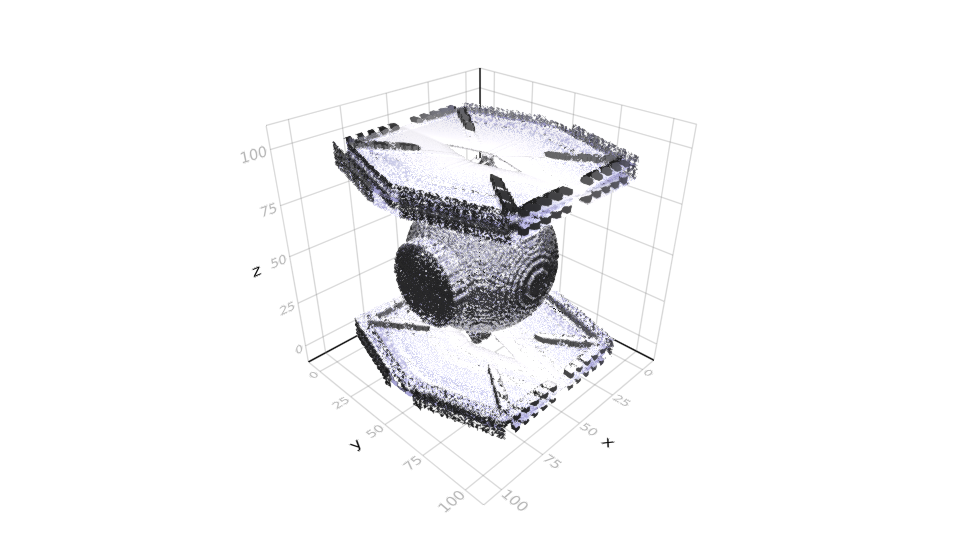

In [47]:
using Makie

 N = 100
 r = range(-1, stop = 1, length = N)

 # bunch of equations and inequalities
 f1(x,y,z) = x.^2 .+ y.^2 .+ z.^2 #center sphere
 f2(x,y,z) = y.^2 .+ z.^2 #command deck cylinder thing
 f3(x,y,z) = x.^2 .+ 4 .* y.^2 #controls the flattened cylinder connecting center pod to wings
 f4(x,y,z) = (y .* 0.7 .+ 0.05) #defines the diagonal spokes
 f5(x,y,z) = (y .* 0.7 .- 0.05) #defines the diagonal spokes
 f6(x,y,z) = abs.(x) + 0.3 .* abs.(y) #frame part of the wings

 e1(x,y,z) = 0.12 .* (1 .- abs.(z)) #limits of a hexagonal tube in the inside of the craft
 e2(x,y,z) = abs.(z) .* (abs.(z) .< 0.95) #outer limits of the wing plane
 e3(x,y,z) = abs.(z) .* (abs.(z) .> 0.9) #inner limits of the wing plane
 e4(x,y,z) = (abs.(x) + abs.(0.3 .*y)) .* ((abs.(x) + abs.(0.3 .* y)) .< 1) #frame of the wings
 e5(x,y,z) = abs.(z) .* (abs.(z) .< 1.05) #outside thickness of wing frames, including the spokes
 e6(x,y,z) = abs.(z) .* (abs.(z) .> 0.80) #inside thickness of wing frames, including the spokes
 e7(x,y,z) = abs.(x) .* (abs.(x) .< 0.7) #length of the straight bars part of frames
 e8(x,y,z) = abs.(y) .* (abs.(y) .> 0.9) #width of the straight bars part of frames
 e9(x,y,z) = abs.(y) .* (abs.(y) .< 0.035) #the thickness of the horizontal reinforcing bar on the wing planes

 amp = 15 #this just amplifies the "strength" of a volume, so that it shows up more clearly in the plot

 # spawn the tie fighter
 me = [(f1(x,y,z) .* f1(x,y,z).<0.2) .+ ((f2(x,y,z) .* f2(x,y,z).<0.02).*((x.<0.68).*(x.>0.50))) .+ amp .* (f3(x,y,z) .* (f3(x,y,z) .< e1(x,y,z))) .+ (e2(x,y,z).*e3(x,y,z).*e4(x,y,z)) .+ (e5(x,y,z).*e6(x,y,z)).*((e7(x,y,z)).*(e8(x,y,z)) .+ e9(x,y,z) .+ ((x.>f5(x,y,z)).*x).*((x.<f4(x,y,z)).*x) .+ (((-).(x).>f5(x,y,z)).*x).*(((-).(x).<f4(x,y,z)).*x) .+ ((f6(x,y,z).*(f6(x,y,z).<1.05)).*(f6(x,y,z).*(f6(x,y,z).>0.95)))) for x=r, y=r, z=r]

 me2 = me
 for i = 1:length(r)
     me2[:,:,i] = me2[:,:,i] .- min(me2[:,:,i]...)
     me2[:,:,i] = me2[:,:,i] ./ max(me2[:,:,i]...)
 end
 contour(me2, colormap = :Purples, colorrange = (0.001,0.6), alpha = 1.0, levels = 10)